## Introduction

This blog post aims to explore the Palmer's Penguins dataset. This will be done with visualizations and models, leading to predictions of species on the data. In particular, I will perform cross-validation techniques on the data to see which models and parameters yield the highest accuracy predictions. After choosing the most accurate models, I will graph the model's decision boundaries to learn about the predictions being made.

## Data Collection and Preparation

To classify the Palmer Penguins, I first had to import the data set into my Python environment:

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

I then checked the elements of set. This would give me an idea of what could be used for visualization and to train the models.

In [2]:
train.keys()

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'],
      dtype='object')

Let's look at the top of the data:

In [3]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


This provided function prepares the data by dropping non-helpful elements (i.e. identifying or helpful information to scientists working with the data that isn't useful to the model). Species values are also encoded into numerical values so they can be output by the computer. Useless values like "." sex penguins and NA value entires are also dropped from the set. This function creates X_train and y_train data that will be used throughout the fitting process, with X_train being the valid columns of the dataframe and y_train being the species (result) column.

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [5]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


## Cross Validation Testing

The following code tests different models on a variety of elements in the data. The qualitative and quantitative columns are put into individual arrays and are matched in groups of three (one qualitative column and two quantitative columns) using the combinations function from itertools. The different models -- logistic regression, decision tree, random forest, and support vector from sklearn's library -- are tested using cross-validation to ensure models that overfit aren't chosen. For the support vector and decision tree classifiers, other parameters (gamma and max depth respectively) are iterated over to ensure the highest score possible. For each model fit, the columns used, score, and extra parameters are appended to their results array. These results are sorted in descending order by highest score and a truncated version of each is printed out at the end of fitting. This allows for me to choose the best model and elements to fit to predict the test data.

In [6]:
from sklearn.exceptions import ConvergenceWarning
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore") # just ignores the convergence warning in this case

results_LR = []
results_SVC = []
results_DTC = []
results_RFC = []

all_qual_cols = ["Island", "Stage", "Clutch Completion", "Sex"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
                  'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 

    LR = LogisticRegression()

    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    new_score_LR = cv_scores_LR.mean()
    results_LR.append((new_score_LR, cols))
    
    for g in 10.0**np.arange(-5, 5):
      SVM = SVC(gamma = g)
      cv_scores_SVC = cross_val_score(SVM, X_train[cols], y_train, cv = 5)
      new_score_SVC = cv_scores_SVC.mean()
      results_SVC.append((new_score_SVC, cols, SVM.gamma))

    for m in np.arange(2, 25):
      DTC = DecisionTreeClassifier(max_depth = m)

      cv_scores_DTC = cross_val_score(DTC, X_train[cols], y_train, cv = 5)
      new_score_DTC = cv_scores_DTC.mean()
      results_DTC.append((new_score_DTC, cols, DTC.max_depth))

    RFC = RandomForestClassifier()

    cv_scores_RFC = cross_val_score(RFC, X_train[cols], y_train, cv = 5)
    new_score_RFC = cv_scores_RFC.mean()
    results_RFC.append((new_score_RFC, cols))
      
print("LR:")
# lamba key tip on tuples from https://docs.python.org/3/howto/sorting.html
results_LR.sort(reverse=True, key=lambda x : x[0])
print(results_LR[:3])

print("SVC:")
results_SVC.sort(reverse=True, key=lambda x : x[0])
print(results_SVC[:3])

print("DTC:")
results_DTC.sort(reverse=True, key=lambda x : x[0])
print(results_DTC[:3])

print("RFC:")
results_RFC.sort(reverse=True, key=lambda x : x[0])
print(results_RFC[:3])

LR:
[(0.9961538461538462, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']), (0.9844645550527904, ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']), (0.9726244343891401, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Delta 13 C (o/oo)'])]
SVC:
[(0.9805429864253394, ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 0.1), (0.9687782805429863, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 0.1), (0.9649321266968325, ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 1.0)]
DTC:
[(0.9765460030165913, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 5), (0.9765460030165913, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 6), (0.9765460030165913, ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen 

## Visualizations

Before creating the models, I wanted to create the visualizations and tables out of the data I just received. I picked the data that I didn't plan on using for the models, but still scored highly in the model fitting. This way, the data representations will be strongly related to the species of the penguin but won't be redundant with the final models. I also had to choose between the different quantitative factors, as I felt that isolating to one factor would clearly show its relation to species. The data table, then, was made by grouping by qualitative factors and returning a quantitative factor.

In [7]:
gb = train.groupby(["Island", "Species"])["Culmen Length (mm)"].aggregate("mean")
print(gb)

Island     Species                                  
Biscoe     Adelie Penguin (Pygoscelis adeliae)          38.845455
           Gentoo penguin (Pygoscelis papua)            47.073196
Dream      Adelie Penguin (Pygoscelis adeliae)          38.826667
           Chinstrap penguin (Pygoscelis antarctica)    48.826316
Torgersen  Adelie Penguin (Pygoscelis adeliae)          39.229268
Name: Culmen Length (mm), dtype: float64


For the visualizations, I chose two quantiative factors from high scoring models, using species as a color factor. This can be achieved easily with seaborn:

<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

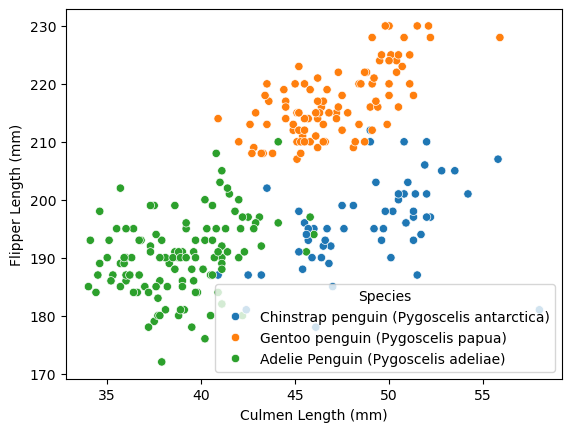

In [8]:
import seaborn as sns

sns.scatterplot(data=train, x="Culmen Length (mm)", y="Flipper Length (mm)", hue="Species")

<Axes: xlabel='Flipper Length (mm)', ylabel='Delta 13 C (o/oo)'>

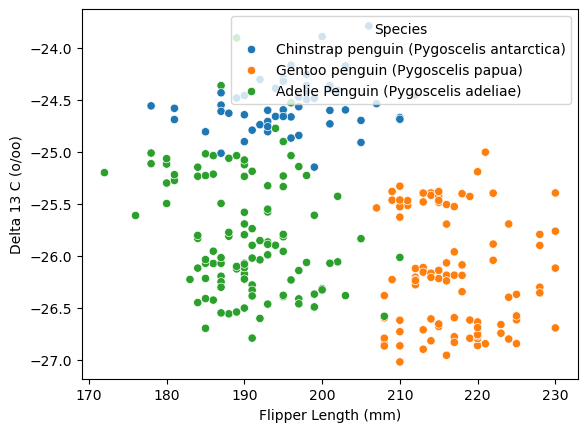

In [9]:
sns.scatterplot(data=train, x="Flipper Length (mm)", y="Delta 13 C (o/oo)", hue="Species")

## Model Creation

To get the models to work, I took the highest scoring three models from the previous cross validation tests. Here, I used sklearn's logistic regression for two of the models and their random forest  classifier for the last one.

In [10]:
from sklearn.linear_model import LogisticRegression

LR_cols_1 = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'] # LR
LR_cols_2 = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE'] # LR
RFC_cols = ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'] # RFC

LR_1 = LogisticRegression()
LR_1.fit(X_train[LR_cols_1], y_train)

LR_2 = LogisticRegression()
LR_2.fit(X_train[LR_cols_2], y_train)

RFC = RandomForestClassifier()
RFC.fit(X_train[RFC_cols], y_train)

RandomForestClassifier()

Finally, the test data is prepared through the same prepare_data function. Then, the models are scored on the test data, with the logistic regression models achieving 100% accuracy!

In [11]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

# Chose top three from above, tested on test data

print("LR1:")
print(LR_1.score(X_test[LR_cols_1], y_test))

print("LR2:")
print(LR_2.score(X_test[LR_cols_2], y_test))

print("RFC: ")
print(RFC.score(X_test[RFC_cols], y_test))

LR1:
1.0
LR2:
1.0
RFC: 
0.9852941176470589


## Decision Boundaries

This provided plot_regions function takes in a model alongside the X and y columns of data and plots the its decision regions, allowing for easy visualization.

In [12]:

from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Finally, I plotted my two logistic regression models (the models that achieved 100% prediction accuracy) using the plot_regions function.

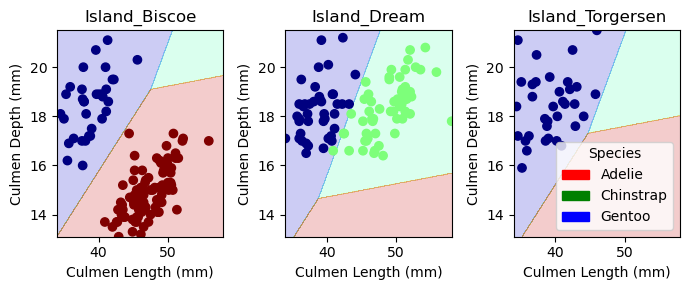

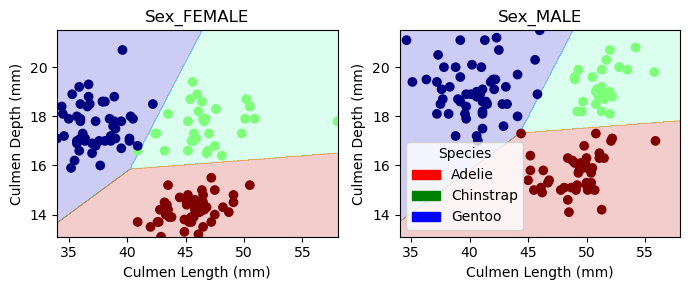

In [13]:
plot_regions(LR_1, X_train[LR_cols_1], y_train)
plot_regions(LR_2, X_train[LR_cols_2], y_train)

## Confusion Matrix

As one more point of information, I created confusion matrices for my LogisticRegression models. In doing so, I showed that each of these models predicts a given species as the correct species across all test data (e.g. there is no instance across either model where an Gentoo is misclassified as a Chinstrap).

In [20]:
from sklearn.metrics import confusion_matrix

y_test_pred_1 = LR_1.predict(X_test[LR_cols_1])
C_1 = confusion_matrix(y_test, y_test_pred_1)

y_test_pred_2 = LR_2.predict(X_test[LR_cols_2])
C_2 = confusion_matrix(y_test, y_test_pred_2)

C_1, C_2

(array([[31,  0,  0],
        [ 0, 11,  0],
        [ 0,  0, 26]], dtype=int64),
 array([[31,  0,  0],
        [ 0, 11,  0],
        [ 0,  0, 26]], dtype=int64))

## Discussion

Through the creation of this blog post, I discovered the best sets of prediction parameters for the given dataset and models (culmen length and depth alongside island of origin and sex, respectively) and showed that logistic regression decision boundaries are linear. Further, I showed other correlations that exist in the dataset -- like the relation of flipper length and delta 13 C to species -- through visualizations of the dataset. In doing this, I improved my skills with dataframes and data cleaning, an essential process for training models. Further, I gained practice with seaborn for visualizing data and learned how to train and cross-validate the prebuilt models from scikit-learn, leading to my first model-based predictions being made on a dataset.